# AWS Sagemaker Notebook Model - Titanic Survival Prediction
## Introduction on making a model on AWS Sagemaker Notebook
The task at hand is to use AWS services to create a model that predicts the survival of a passenger on the Titanic.


## Step 1: Import the necessary libraries

In [103]:
%pip install xlrd
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [104]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import lightgbm as lgb
#import boto3

###  Step 2: Exploring the data
The first step is to explore the data and see what we are working with. The data is stored in a excele file and has been read into a pandas dataframe. The firt 10 row of the data has been displayed above.

Now you need the shape of the data to see how many rows and columns are there in the data.

In [105]:
# mport this file files/titanic3.xls into a dataframe
titanic = pd.read_excel('../files/titanic3.xls')
titanic.head()  

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [106]:
titanic.shape

(1309, 14)

You will now get a list of the columns.

In [107]:
titanic.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

We can see it has 13 features and 1 target variable. The target variable is the Survived column. The features are the rest of the columns.

Next lets check the data types of the columns.

In [108]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

Now lets check for any missing values in the data.

Check for missing values in every feature column

In [109]:
#check for missing values
titanic.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

* There are 263 missing values in the Age column.
* There are 1 missing values in the Fare column.
* There are 1014 missing values in the Cabin column.
* There are 2 missing values in the Embarked column.
* There are 823 missing values in the Boat column.
* There are 1188 missing values in the Body column.
* There are 564 missing values in the home.dest column.
* There are 2 missing values in the embarked column.

Since the many columns have missing values, I would have to drop them all except a column where I can fill with the mean of the column. So columns like Cabin, Boat, Body, home.dest would be dropped.

To make this data more usable for machine we would have to drop features that are not useful for the model. So we would drop the name, ticket, cabin, boat, body, home.dest, embarked and sibsp.

The reason for dropping some columns are as follows:
* Name: The name of the passenger is not useful for the model as it does not have any impact on the survival of the passenger.
* Ticket: The ticket number is not useful for the model as it does not have any impact on the survival of the passenger.
* Cabin: The cabin number is not useful for the model as it does not have any impact on the survival of the passenger.
* Boat: The boat number is not useful for the model as it the passenger already surived if he was on a boat, this would make the model overfit.
* Body: The body although is useful for the model but since it has 1188 missing values, it would be better to drop it.
* Home.dest: The home destination of the passenger is not useful for the model as it does not have any impact on the survival of the passenger.

In [110]:
#delete features that are not useful
titanic.drop(['name','ticket','cabin','boat','body','home.dest','embarked','sibsp'], axis=1, inplace=True)
titanic.head()

,pclass,survived,sex,age,parch,fare
0,1,1,female,29.0000,0,211.3375
1,1,1,male,0.9167,2,151.5500
2,1,0,female,2.0000,2,151.5500
3,1,0,male,30.0000,2,151.5500
4,1,0,female,25.0000,2,151.5500


Now lets drop all rows with null values in the dataset and check the shape of the data.

In [111]:
#remove row with missing values
titanic.dropna(inplace=True)
titanic.shape

(1045, 6)

To make the dataset usable by a ML algorithm we have to change the categorical features. We do this using label encoding. So we have to change the gender in from male to female to 0 and 1 respectively. Also we have to change the Embarked column to numerical values. So we have to change the values in the Embarked column to 0, 1 and 2 respectively.

In [112]:
titanic['sex'] = titanic['sex'].replace({'male': 1, 'female': 0})
titanic.shape

(1045, 6)

Lets have some insights on the data
Lets plot the survival of the sex 

<Axes: >

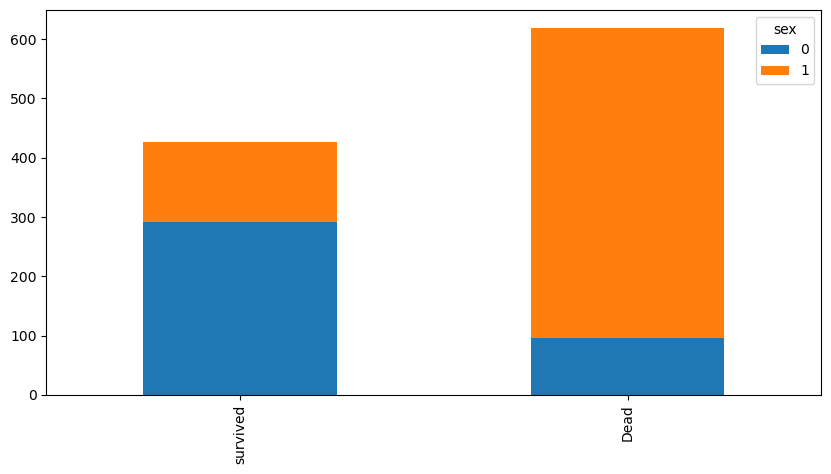

In [113]:
survived = titanic[titanic['survived']==1]["sex"].value_counts()
dead = titanic[titanic['survived']==0]["sex"].value_counts()
df_survived_dead = pd.DataFrame([survived,dead])
df_survived_dead.index = ['survived','Dead']
df_survived_dead.plot(kind='bar',stacked=True, figsize=(10,5))

Plot the survival based on the classes of the tickets. 

<Axes: >

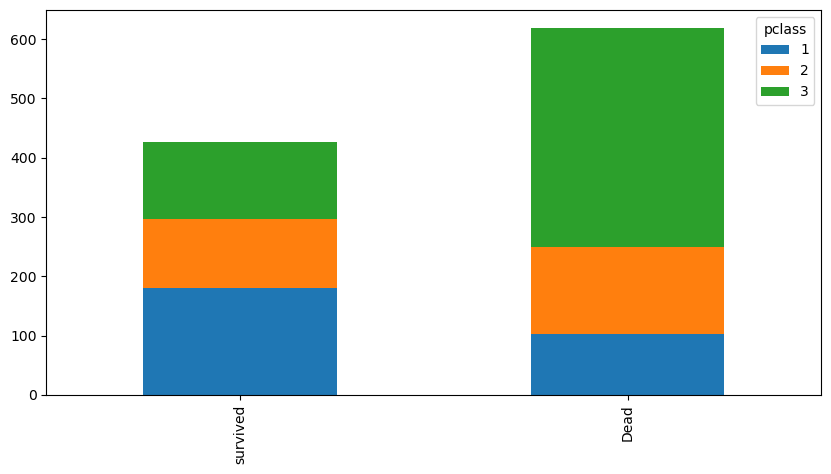

In [114]:
survived = titanic[titanic['survived']==1]["pclass"].value_counts().reindex([1, 2, 3])
dead = titanic[titanic['survived']==0]["pclass"].value_counts().reindex([1, 2, 3])
df_survived_dead = pd.DataFrame([survived,dead])
df_survived_dead.index = ['survived','Dead']
df_survived_dead.plot(kind='bar',stacked=True, figsize=(10,5))

Lets see whats left of the data now

In [115]:
titanic.head()

,pclass,survived,sex,age,parch,fare
0,1,1,0,29.0000,0,211.3375
1,1,1,1,0.9167,2,151.5500
2,1,0,0,2.0000,2,151.5500
3,1,0,1,30.0000,2,151.5500
4,1,0,0,25.0000,2,151.5500


 Now, we want to explore the relationships between the features and the target variable, 'survived'. To do this, we can calculate the correlation matrix between the features and the target variable. This will help us identify which features have a strong correlation with the target variable and can be used to build a predictive model. We will use the seaborn library to plot a heatmap of the correlation matrix.

 As we can there is no feature which has zero correlation with the target variable. So we can use all the features to build our model.

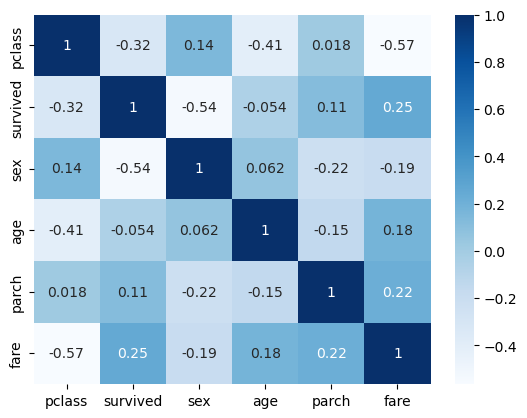

In [116]:
# Calculate the correlation matrix
corr = titanic.corr()
# Plot the heatmap
sns.heatmap(corr, annot=True, cmap="Blues")
plt.show()

Another easier way os to use a bar chart to visualize the correlation between the features and the target variable. We can use the plot function in seaborn to do this. Bar chart pointing downwards means negative correlation and bar chart pointing upwards means positive correlation.

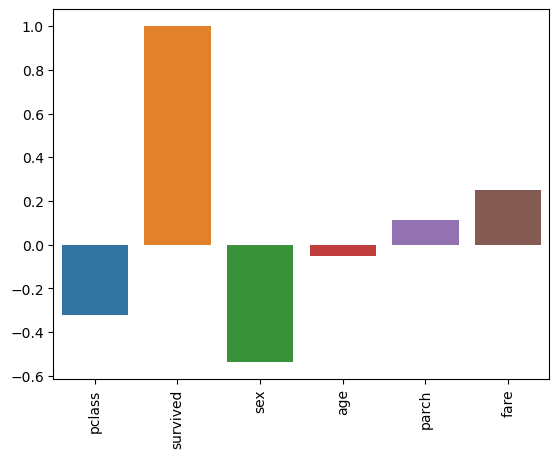

pclass     -0.319979
survived    1.000000
sex        -0.537719
age        -0.053958
parch       0.114091
fare        0.249164
dtype: float64


In [117]:
corr_matrix = titanic.corrwith(titanic['survived'])

sns.barplot(x=corr_matrix.index, y=corr_matrix.values)

plt.xticks(rotation=90)

plt.show()

print(corr_matrix)

Now lets check to find some outliers in the data. We can use the boxplot function in seaborn to do this. As we can see below thre are some outliers in fare, age and parch. The only way to find out if removing these outliers would thorw off my model was by training it and doing that reduced the accuracy of my model. So I decided to keep the outliers.

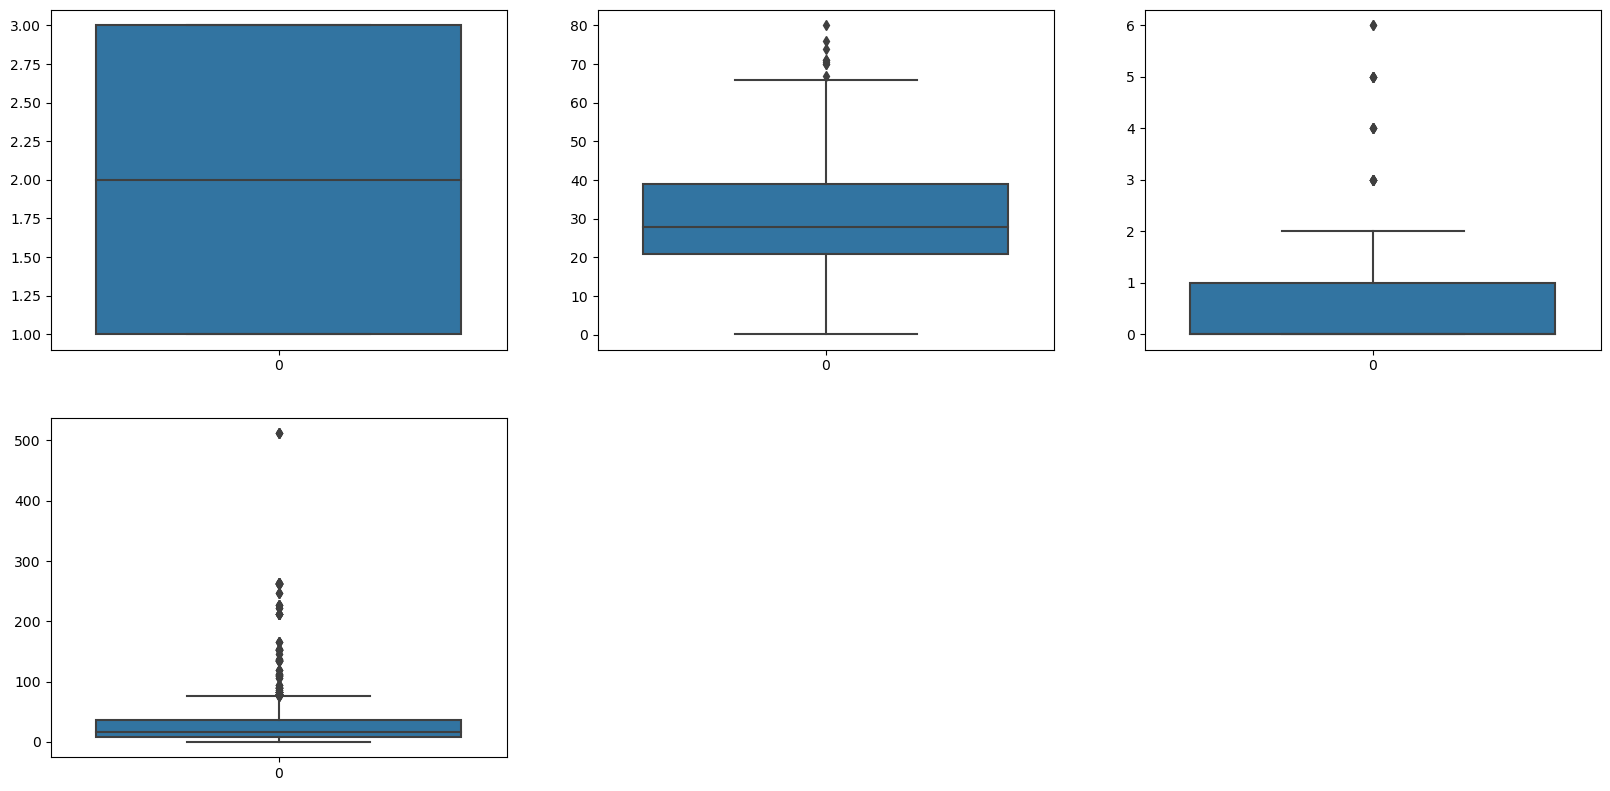

(1045, 6)

In [118]:
#plot a boxplot for all the features to see the outliers
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
sns.boxplot(titanic['pclass'])
plt.subplot(3,3,2)
sns.boxplot(titanic['age'])
plt.subplot(3,3,3)
sns.boxplot(titanic['parch'])
plt.subplot(3,3,4)
sns.boxplot(titanic['fare'])
plt.show()

#show the number of rows and columns
titanic.shape


## Step 3: Preparing the data for the model

In [119]:
cols = titanic.columns.tolist()
# move second column to first
cols = cols[1:2] + cols[0:1] + cols[2:]
titanic = titanic[cols]
titanic.head()

,survived,pclass,sex,age,parch,fare
0,1,1,0,29.0000,0,211.3375
1,1,1,1,0.9167,2,151.5500
2,0,1,0,2.0000,2,151.5500
3,0,1,1,30.0000,2,151.5500
4,0,1,0,25.0000,2,151.5500


### Splitting the data into training and testing sets
I would start by splitting the data into training and testing sets. I would use 80% of the data for training and 20% for testing. I would use the train_test_split function in sklearn to do this. I would then split the test data into test and validation sets. I would use 10% of the data for testing and 10% for validation. I would use the train_test_split function in sklearn to do this.

In [120]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(titanic, test_size=0.2, random_state=42, stratify=titanic['survived'])

Next, split the *test_and_validate* dataset into two equal parts.

In [121]:
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['survived'])

Now lets examine the three datasets.

In [122]:
print(train.shape)
print(test.shape)
print(validate.shape)

(836, 6)
(104, 6)
(105, 6)


Now lets check the distribution of the classes in the three datasets.

In [123]:
print(train['survived'].value_counts())
print(test['survived'].value_counts())
print(validate['survived'].value_counts())

survived
0    494
1    342
Name: count, dtype: int64
survived
0    62
1    42
Name: count, dtype: int64
survived
0    62
1    43
Name: count, dtype: int64


### Uploading the data to S3

XGboost will load the data for training from Amazon Simple Storage Service (Amazon S3). Thus, you must write the data to a comma-separated values (CSV) file, and then upload the file to Amazon S3.

Start by setting up some variables to the S3 bucket, then create a function to upload the CSV file to Amazon S3.

In [124]:
bucket='c93435a2086646l5177631t1w35831479992-flightbucket-b6evrqfmgs39'

prefix='lab3'

train_file='titanic_train.csv'
test_file='titanic_test.csv'
validate_file='titanic_validate.csv'

import os

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Use the function to upload the three datasets to Amazon S3.

In [125]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

## Step _: Train the XGBoost model
Now that the data has been uploaded to Amazon S3, you can train the XGBoost model. To begin, you need to specify the type of training job you want to run and the input and output locations in Amazon S3. 

In [126]:
import boto3
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Next, you must set some *hyperparameters* for the model. Because this is the first time you are training the model, you can use some values to get started.

In [127]:
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

Use the **estimator** function to set up the model. Here are a few parameters of interest:

- **instance_count** - This defines how many instances will be used for training. You will use *one* instance.
- **instance_type** - This defines the instance type for training. In this case, it's *ml.m4.xlarge*.


In [128]:
import sagemaker
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


The estimator needs *channels* to feed data into the model. For training, the *train_channel* and *validate_channel* will be used.

In [129]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

Running **fit** will train the model.

**Note:** This process can take up to 5 minutes.

In [130]:
xgb_model.fit(inputs=data_channels, logs=False)
print("Ready for hosting")

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-04-16-08-16-471



2023-11-04 16:08:16 Starting - Starting the training job...
2023-11-04 16:08:40 Starting - Preparing the instances for training...................
2023-11-04 16:10:20 Downloading - Downloading input data.....
2023-11-04 16:10:51 Training - Downloading the training image........
2023-11-04 16:11:36 Training - Training image download completed. Training in progress.....
2023-11-04 16:12:02 Uploading - Uploading generated training model.
2023-11-04 16:12:12 Completed - Training job completed
Ready for hosting


## Setup hosting for the model

In [131]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-04-16-12-13-995
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-04-16-12-13-995
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-04-16-12-13-995


-------!

## Perform predictions with the model


In [132]:
row = test.iloc[0:1,1:]
row.head()

,pclass,sex,age,parch,fare
497,2,1,40.0,0,16.0


In [133]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

2,1,40.0,0,16.0



In [134]:
xgb_predictor.predict(test_row)

b'0.06679876893758774'

In [135]:
test.head(5)

,survived,pclass,sex,age,parch,fare
497,0,2,1,40.00,0,16.0000
1068,0,3,1,61.00,0,6.2375
658,1,3,0,0.75,1,19.2583
818,1,3,0,16.00,0,7.7333
937,0,3,0,1.00,1,12.1833


### Now terminate the endpoint

To delete the endpoint, use the **delete_endpoint** function on the predictor.

In [136]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-11-04-16-12-13-995
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-11-04-16-12-13-995


### Step _: Perform Batch Transform job

In [137]:
batch_X = test.iloc[:,1:];
batch_X.head()

,pclass,sex,age,parch,fare
497,2,1,40.00,0,16.0000
1068,3,1,61.00,0,6.2375
658,3,0,0.75,1,19.2583
818,3,0,16.00,0,7.7333
937,3,0,1.00,1,12.1833


Write you data to csv

In [138]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

Last, before you perform a transform, configure your transformer with the input file, output location, and instance type.

In [139]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-04-16-16-16-825
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-04-16-16-17-446


.....................................[2023-11-04:16:22:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-04:16:22:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-04:16:22:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-04:16:22:24:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      re

After the transform completes, you can download the results from Amazon S3 and compare them with the input.

First, download the output from Amazon S3 and load it into a pandas DataFrame.


In [140]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])

## Exploring the results
You can use a function to convert the probabilty into either a *0* or a *1*.

The first table output will be the *predicted values*, and the second table output is the *original test data*.

In [141]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    1
3    1
4    1
Name: class, dtype: int64


,survived,pclass,sex,age,parch,fare
497,0,2,1,40.00,0,16.0000
1068,0,3,1,61.00,0,6.2375
658,1,3,0,0.75,1,19.2583
818,1,3,0,16.00,0,7.7333
937,0,3,0,1.00,1,12.1833


## Creating a confusion matrix

In [142]:
test_labels = test.iloc[:,0]
test_labels.head()

497     0
1068    0
658     1
818     1
937     0
Name: survived, dtype: int64

Use scikit-learn to create a confusion matrix.

In [143]:

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,57,5
Abnormal,12,30


Use seaborn to create a heatmap of the confusion matrix.

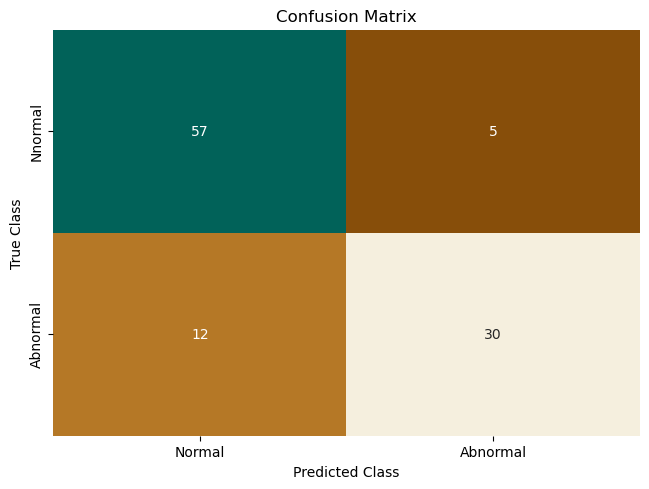

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Print the accuracy of the model.

In [145]:
#calculate accuracy
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, target_predicted_binary)


0.8365384615384616

In [1]:
#Save the model
import pickle
pickle.dump(xgb_model, open("saved_models/titanic_model.pkl", "wb"))



NameError: name 'xgb_model' is not defined